In [1]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig, TaskType

In [2]:
df = pd.read_csv("./low_confidence_samples/big_data.csv")
df

,Unnamed: 0,text,label,preprocess_text
0,43,Having certain businesses with skill sets in y...,2,have certain business skill set local neighbor...
1,143,We came here on a Saturday night and luckily i...,2,come saturday night luckily pack think love pl...
2,167,For a brewery who is attempting to take advant...,1,brewery attempt advantage oktoberf wonder 7 pm...
3,175,I'm a regular here since their kitchen is open...,2,regular kitchen open late good option movie na...
4,213,"haha only came here once for happy hour, but i...",2,haha come happy hour pleased price guess come ...
...,...,...,...,...
25667,678858,Just... wow! So many guns. So much ammunition....,2,... wow gun ammunition hunting gear outside ge...
25668,678922,This place is was not that great. Dim sum is o...,1,place great dim sum outranglusly expensive ran...
25669,678925,"So Marcus, the owner, saw my wife and I passin...",2,marcus owner see wife pass star sandwhich shop...
25670,678943,We just left and will go back for burgers anyt...,2,leave burger anytime mood.\n\n5 minute wait ta...


In [3]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True)

# Ensure text data is a list of strings and drop missing values
df_train["text"] = df_train["preprocess_text"].astype(str)
df_test["text"] = df_test["preprocess_text"].astype(str)

# Ensure text is lowercase
df_train["text"] = df_train["text"].str.lower()
df_test["text"] = df_test["text"].str.lower()

df_train["label"] = df_train["label"].astype(int)
df_test["label"] = df_test["label"].astype(int)

In [4]:
df_train

,Unnamed: 0,text,label,preprocess_text
4023,131536,live valley year rave pricing great bargain fi...,1,live valley year rave pricing great bargain fi...
12087,376930,huge critic come sandwich shop big place open ...,1,huge critic come sandwich shop big place open ...
11979,373126,profession take lot drug test application proc...,2,profession take lot drug test application proc...
22809,622862,r lost trooper want know,0,r lost trooper want know
16636,526567,daughter visit today time staff courteous be...,1,daughter visit today time staff courteous be...
...,...,...,...,...
17261,550257,sport bar offer chicken wing slider bar gaming...,2,sport bar offer chicken wing slider bar gaming...
20513,595084,nagra come conservative indian family exactly ...,2,nagra come conservative indian family exactly ...
24296,639065,... long install sbs2008,0,... long install sbs2008
24313,639244,wooohooo i`m fourth row,1,wooohooo i`m fourth row


In [6]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train[["text", "label"]])
test_dataset = Dataset.from_pandas(df_test[["text", "label"]])


# Adding short max length to lower training time
def tokenize_function(examples):
    return tokenizer(
        examples["text"], padding="max_length", truncation=True, max_length=512
    )


tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17970 [00:00<?, ? examples/s]

Map:   0%|          | 0/7702 [00:00<?, ? examples/s]

In [8]:
import torch

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)

Using device: mps


In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],  # BERT uses query, key, value in attention
    lora_dropout=0.1,
    bias="all",
    task_type=TaskType.SEQ_CLS,
)

training_args = TrainingArguments(
    output_dir="./results/" + model_name,
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    # gradient_checkpointing=True,
    num_train_epochs=2,
    dataloader_num_workers=0,
    logging_steps=100,
    optim="adamw_torch",
    # weight_decay=0.01,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
)

# model = get_peft_model(model, lora_config)
model = model.to(device)

for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Define a compute metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    accuracy = accuracy_score(p.label_ids, preds)
    return {"accuracy": accuracy}

In [26]:
from transformers import TrainerCallback


class LossAccuracyLogger(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_accuracy = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_loss.append((state.epoch, logs["loss"]))
            if "eval_accuracy" in logs:
                self.eval_accuracy.append((state.epoch, logs["eval_accuracy"]))

In [27]:
logger_callback = LossAccuracyLogger()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger_callback],
)

In [ ]:
# Train the model
trainer.train()

In [ ]:
trainer.save_model("./results/" + model_name + "v1")

{'eval_loss': 0.9946369528770447, 'eval_accuracy': 0.448334644636769, 'eval_runtime': 72.0795, 'eval_samples_per_second': 105.8, 'eval_steps_per_second': 6.618, 'epoch': 3.0}


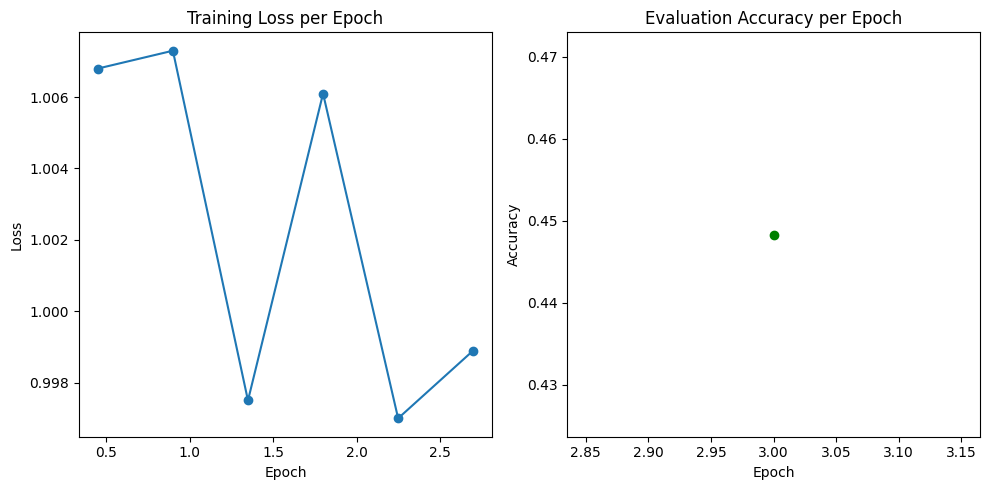

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

import matplotlib.pyplot as plt

# Unpack the epoch and values
train_epochs, train_losses = zip(*logger_callback.train_loss)
eval_epochs, eval_accuracies = zip(*logger_callback.eval_accuracy)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_losses, marker="o")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot eval accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_accuracies, marker="o", color="green")
plt.title("Evaluation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate fine-tuned model on all samples, including non low confidence ones
df_test = pd.read_csv("./data/SA_cleaned.csv")
df_test["text"] = df_test["preprocess_text"].astype(str)
df_test["label"] = df_test["label"].astype(int)
df_test

,Unnamed: 0,text,label,preprocess_text
0,0,reviewer mention watch 1 oz episode hook right...,2,reviewer mention watch 1 oz episode hook right...
1,1,wonderful little production br /><br />the fil...,2,wonderful little production br /><br />the fil...
2,2,think wonderful way spend time hot summer week...,2,think wonderful way spend time hot summer week...
3,3,basically family little boy jake think zombie ...,0,basically family little boy jake think zombie ...
4,4,petter mattei love time money visually stunnin...,2,petter mattei love time money visually stunnin...
...,...,...,...,...
678506,679009,ryan good yelp claim courteous knowledgable he...,2,ryan good yelp claim courteous knowledgable he...
678507,679010,professional \nfriendly\non time affordable!\n...,2,professional \nfriendly\non time affordable!\n...
678508,679011,phone call voicemail message return stupid w...,1,phone call voicemail message return stupid w...
678509,679012,look like good review go head place jason ry...,1,look like good review go head place jason ry...


In [ ]:
test_dataset = Dataset.from_pandas(df_test[["text", "label"]])
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger_callback],
)

results_all = trainer.evaluate()
print(results_all)